### 代码实现

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

### VAE

In [2]:
# 设备配置，若可用GPU则使用，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义数据预处理方法，将数据转换为 Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 加载 MNIST 数据集
mnist_dataset = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
# 加载数据，并使用 DataLoader 进行分批处理，batch_size 设置为 64
train_loader = torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=64, shuffle=True, num_workers=4)

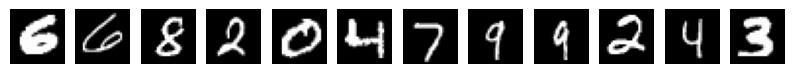

In [3]:
# 设置随机数种子，以便在多次运行代码时得到相同的结果
torch.manual_seed(42)

# 定义要显示的样本数量
num_samples = 12

# 创建一个matplotlib绘图窗口，并显示指定数量的MNIST样本
fig, axs = plt.subplots(1, num_samples, figsize=(10,10))
for i in range(num_samples):
    # 从MNIST数据集中随机选择一个样本
    idx = torch.randint(len(mnist_dataset), size=(1,)).item()
    # 获取该样本的图像信息
    img, _ = mnist_dataset[idx]
    # 在绘图窗口中显示该样本的图像
    axs[i].imshow(img.squeeze(), cmap='gray')
    # 不显示坐标轴
    axs[i].axis('off')
# 显示
plt.show()

In [4]:
# 定义参数
input_dim = 28  # MNIST数据集图像长宽
latent_dim = 2  # 隐变量维度

In [5]:
# 定义VAE的网络结构
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # 编码器部分，都使用全连接
        self.fc1 = nn.Linear(x_dim, h_dim1)   # 输入x_dim，输出h_dim1
        self.fc2 = nn.Linear(h_dim1, h_dim2)  # 输入h_dim1，输出h_dim2
        self.fc31 = nn.Linear(h_dim2, z_dim)  # 输入h_dim2，输出z_dim，输出mu，均值
        self.fc32 = nn.Linear(h_dim2, z_dim)  # 输入h_dim2，输出z_dim，输出log_var，方差的对数

        # 解码器部分，都使用全连接
        self.fc4 = nn.Linear(z_dim, h_dim2)   # 输入z_dim，输出h_dim2
        self.fc5 = nn.Linear(h_dim2, h_dim1)  # 输入h_dim2，输出h_dim1
        self.fc6 = nn.Linear(h_dim1, x_dim)   # 输入h_dim1，输出x_dim
    
    # 编码器处理部分
    def encoder(self, x):
        # 全连接+ReLU
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        # 返回mu和log_var
        return self.fc31(h), self.fc32(h) 
    
    # 解码器处理部分
    def decoder(self, z):
        # 全连接+ReLU
        h = torch.relu(self.fc4(z))
        h = torch.relu(self.fc5(h))
        # 接sigmoid激活函数，输出重建后的x
        return torch.sigmoid(self.fc6(h)) 
    
    # 重参数化技巧
    def sampling(self, mu, log_var):
        # 计算标准差
        std = torch.exp(0.5*log_var)
        # 从标准正态分布中随机采样eps
        eps = torch.randn_like(std)
        # 返回z
        return mu + eps * std
    
    # 定义前向传播函数
    def forward(self, x):
        # 编码器，输出mu和log_var
        mu, log_var = self.encoder(x.view(-1, input_dim*input_dim))
        # 重参数化
        z = self.sampling(mu, log_var)
        # 返回解码器输出、mu、log_var和z
        return self.decoder(z), mu, log_var, z

In [6]:
# 实例化VAE模型
vae = VAE(x_dim=input_dim*input_dim, h_dim1= 512, h_dim2=256, z_dim=latent_dim).to(device)

# 定义Adam优化器，用于优化VAE模型的参数，学习率0.001
optimizer = optim.Adam(vae.parameters(), lr = 0.001)

# 定义VAE的损失函数，其中包含重构误差和KL散度
def loss_function(recon_x, x, mu, log_var):
    # 重构误差，使用二元交叉熵损失函数
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim*input_dim), reduction='sum')
    
    # KL散度，计算高斯分布之间的散度
    # 详见VAE论文中的Appendix B
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # 将重构误差和KL散度相加作为总损失
    return BCE + KLD

====> Epoch: 0 Average loss: 195.4381


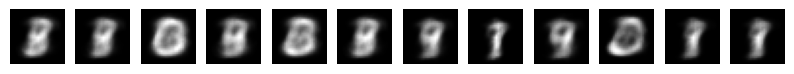

====> Epoch: 1 Average loss: 168.8836


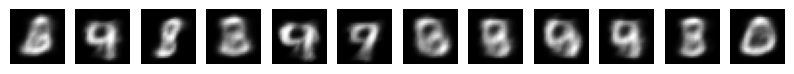

====> Epoch: 2 Average loss: 160.7922


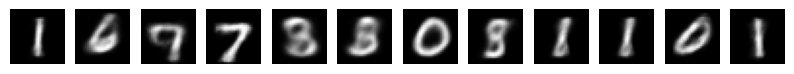

====> Epoch: 3 Average loss: 155.9440


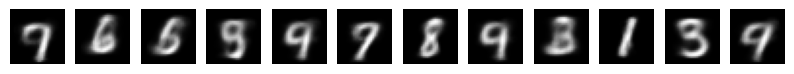

====> Epoch: 4 Average loss: 152.7832


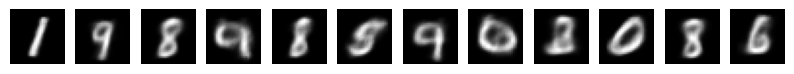

====> Epoch: 5 Average loss: 150.7223


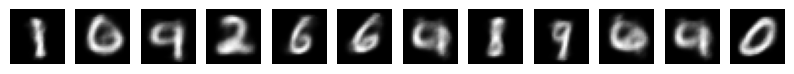

====> Epoch: 6 Average loss: 149.0875


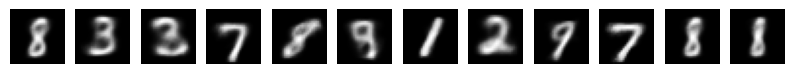

====> Epoch: 7 Average loss: 147.7113


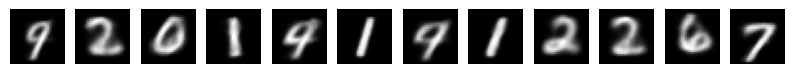

====> Epoch: 8 Average loss: 146.9479


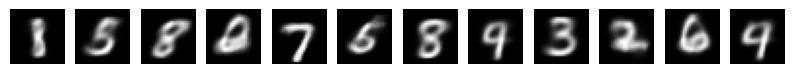

====> Epoch: 9 Average loss: 145.7314


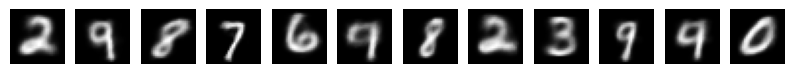

====> Epoch: 10 Average loss: 144.9376


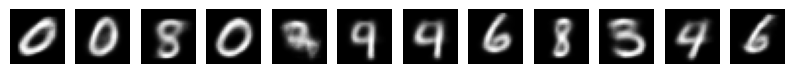

====> Epoch: 11 Average loss: 144.3834


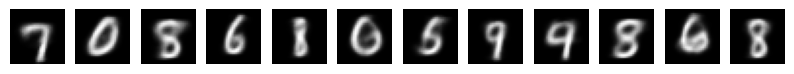

====> Epoch: 12 Average loss: 143.8721


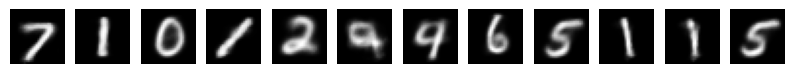

====> Epoch: 13 Average loss: 143.6133


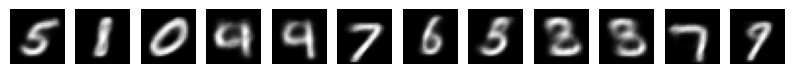

====> Epoch: 14 Average loss: 142.7361


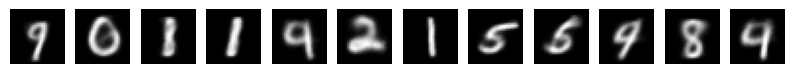

====> Epoch: 15 Average loss: 142.3717


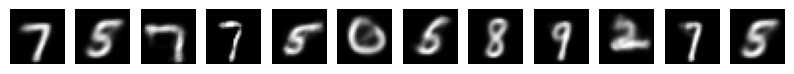

====> Epoch: 16 Average loss: 142.1068


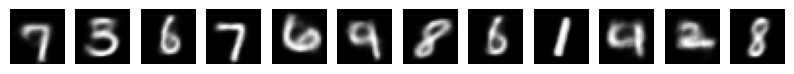

====> Epoch: 17 Average loss: 141.8197


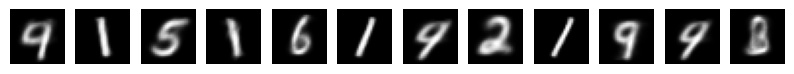

====> Epoch: 18 Average loss: 141.4181


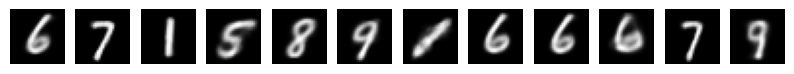

====> Epoch: 19 Average loss: 141.2291


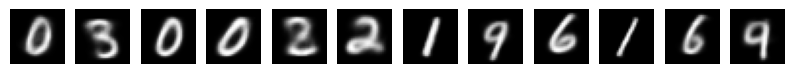

In [7]:
# 定义训练轮数
n_epochs = 20

# 循环开始训练
for epoch in range(n_epochs):
    
    # 进入训练模式
    vae.train()
    train_loss = 0
    
    # 遍历训练数据集
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # 前向传播，计算重构误差和KL散度
        recon_batch, mu, log_var, z = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        # 反向传播，记录损失值，更新模型参数
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # 输出平均损失
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    # 进入评估模式
    vae.eval()
    # 生成新样本
    with torch.no_grad():
        # 随机生成正态分布，并使用解码器将采样结果转换为新的样本
        z = torch.randn(num_samples, latent_dim).to(device)
        sample = vae.decoder(z).cpu()
        images = sample.view(num_samples, input_dim, input_dim).numpy()

        # 可视化生成的样本
        fig, axs = plt.subplots(1, num_samples, figsize=(10,10))
        for i in range(num_samples):
            axs[i].imshow(images[i], cmap='gray')
            axs[i].axis('off')
        plt.show()

### GAN

In [8]:
# 定义超参数
noise_dim = 100  # 随机噪声维度

In [9]:
# 定义数据预处理方法，将数据转换为 Tensor，并进行归一化
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize([0.5], [0.5])   # 进行归一化，均值为0.5，标准差为0.5
])

# 加载 MNIST 数据集
mnist_dataset = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
# 加载数据，并使用 DataLoader 进行分批处理，batch_size 设置为 64
train_loader = torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=64, shuffle=True, num_workers=4)

In [10]:
# 定义生成器模型
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 定义每个block的结构，全连接+BN+ReLU
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)] # 全连接
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat)) # BN层
            layers.append(nn.ReLU(inplace=True)) # ReLU激活函数
            return layers

        # 定义生成器的网络结构，4个block
        self.model = nn.Sequential(
            *block(noise_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, input_dim * input_dim), # 全连接层输出
            nn.Tanh() # Tanh激活函数，将输出映射到[-1,1]之间
        )

    # 定义前向传播函数
    def forward(self, z):
        # 经过生成器模型
        img = self.model(z)
        # 调整输出维度
        img = img.view(-1, 1, input_dim, input_dim)
        return img

In [11]:
# 定义判别器模型
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 定义判别器的网络模型，3个全连接层
        self.model = nn.Sequential(
            # 全连接层，输入维度为28*28，输出维度为512
            nn.Linear(input_dim * input_dim, 512),
            # ReLU激活函数
            nn.ReLU(inplace=True),
            # 全连接层，输入维度为512，输出维度为256
            nn.Linear(512, 256),
            # ReLU激活函数
            nn.ReLU(inplace=True),
            # 全连接层，输入维度为256，输出维度为1
            nn.Linear(256, 1),
            # sigmoid激活函数，将输出映射到(0,1)之间
            nn.Sigmoid(),
        )

    def forward(self, x):
        # flatten将x的维度降为一维
        x = torch.flatten(x, 1)
        # 输入x并计算输出
        x = self.model(x)
        return x

In [12]:
# 定义二元交叉熵损失函数
adversarial_loss = torch.nn.BCELoss().to(device)

# 实例化生成器和判别器
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 定义生成器和判别器的优化器，都使用Adam算法，学习率设为0.001，betas设为(0.5, 0.999)
optimizer_G = torch.optim.Adam(generator.parameters(), lr = 0.001, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = 0.001, betas=(0.5, 0.999))

====> Epoch: 0 Generator loss: 0.0182 Discriminator loss: 0.0084


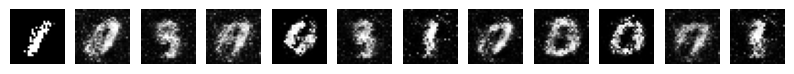

====> Epoch: 1 Generator loss: 0.0153 Discriminator loss: 0.0093


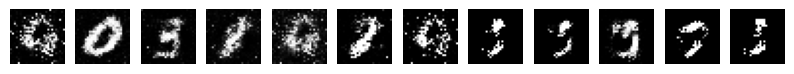

====> Epoch: 2 Generator loss: 0.0156 Discriminator loss: 0.0092


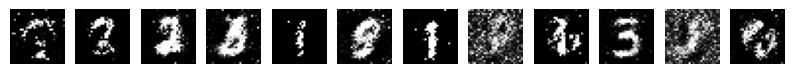

====> Epoch: 3 Generator loss: 0.0142 Discriminator loss: 0.0097


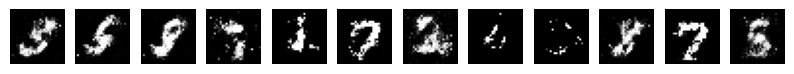

====> Epoch: 4 Generator loss: 0.0139 Discriminator loss: 0.0097


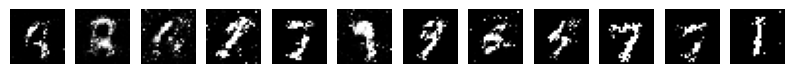

====> Epoch: 5 Generator loss: 0.0139 Discriminator loss: 0.0098


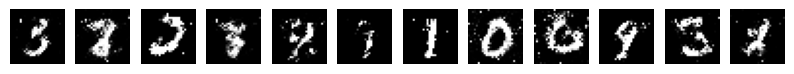

====> Epoch: 6 Generator loss: 0.0140 Discriminator loss: 0.0098


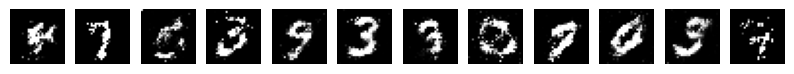

====> Epoch: 7 Generator loss: 0.0144 Discriminator loss: 0.0096


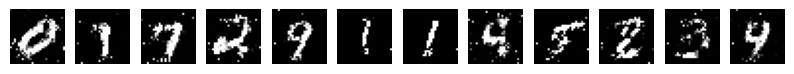

====> Epoch: 8 Generator loss: 0.0151 Discriminator loss: 0.0093


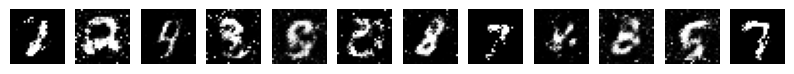

====> Epoch: 9 Generator loss: 0.0162 Discriminator loss: 0.0090


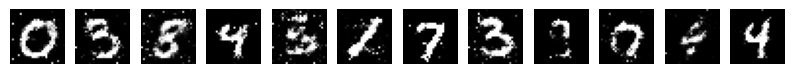

====> Epoch: 10 Generator loss: 0.0161 Discriminator loss: 0.0091


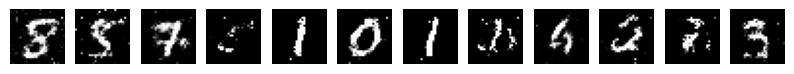

====> Epoch: 11 Generator loss: 0.0166 Discriminator loss: 0.0090


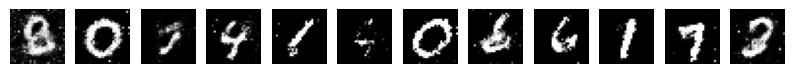

====> Epoch: 12 Generator loss: 0.0168 Discriminator loss: 0.0089


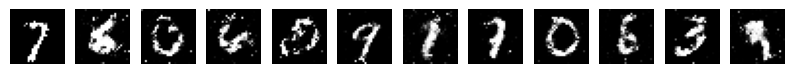

====> Epoch: 13 Generator loss: 0.0165 Discriminator loss: 0.0090


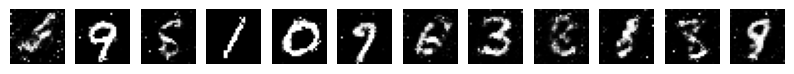

====> Epoch: 14 Generator loss: 0.0160 Discriminator loss: 0.0092


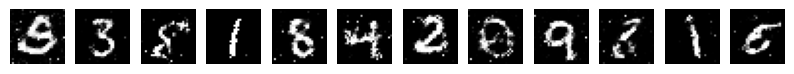

====> Epoch: 15 Generator loss: 0.0160 Discriminator loss: 0.0092


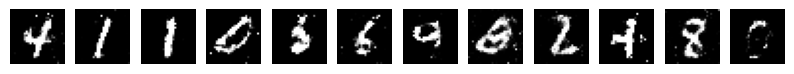

====> Epoch: 16 Generator loss: 0.0160 Discriminator loss: 0.0092


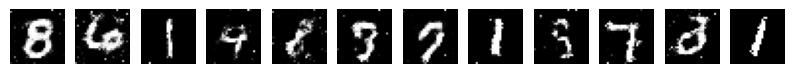

====> Epoch: 17 Generator loss: 0.0154 Discriminator loss: 0.0094


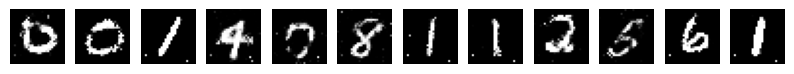

====> Epoch: 18 Generator loss: 0.0152 Discriminator loss: 0.0095


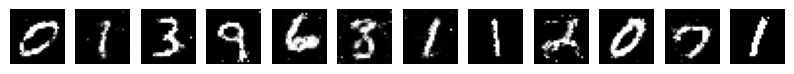

====> Epoch: 19 Generator loss: 0.0147 Discriminator loss: 0.0096


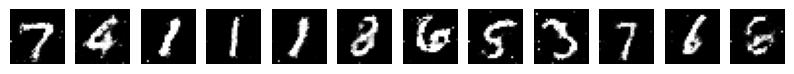

====> Epoch: 20 Generator loss: 0.0147 Discriminator loss: 0.0096


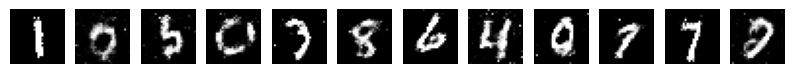

====> Epoch: 21 Generator loss: 0.0144 Discriminator loss: 0.0097


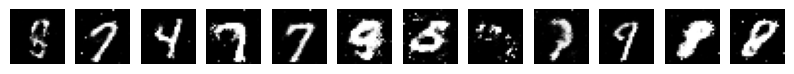

====> Epoch: 22 Generator loss: 0.0142 Discriminator loss: 0.0097


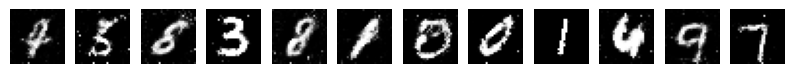

====> Epoch: 23 Generator loss: 0.0139 Discriminator loss: 0.0098


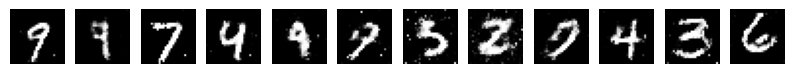

====> Epoch: 24 Generator loss: 0.0136 Discriminator loss: 0.0099


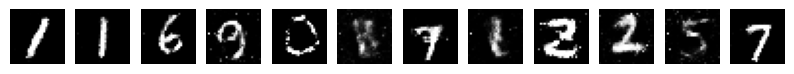

====> Epoch: 25 Generator loss: 0.0135 Discriminator loss: 0.0100


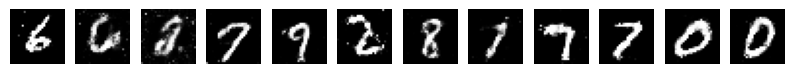

====> Epoch: 26 Generator loss: 0.0133 Discriminator loss: 0.0100


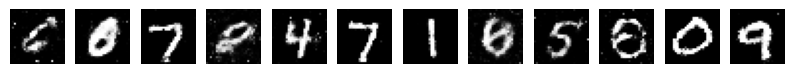

====> Epoch: 27 Generator loss: 0.0133 Discriminator loss: 0.0100


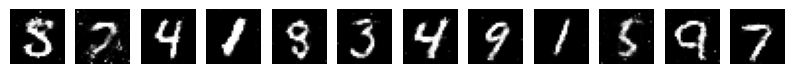

====> Epoch: 28 Generator loss: 0.0131 Discriminator loss: 0.0101


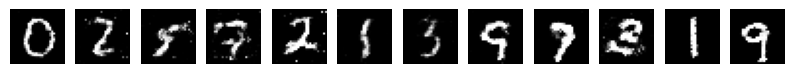

====> Epoch: 29 Generator loss: 0.0131 Discriminator loss: 0.0101


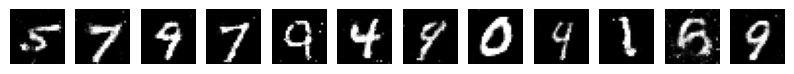

====> Epoch: 30 Generator loss: 0.0131 Discriminator loss: 0.0101


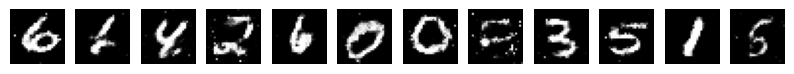

====> Epoch: 31 Generator loss: 0.0131 Discriminator loss: 0.0101


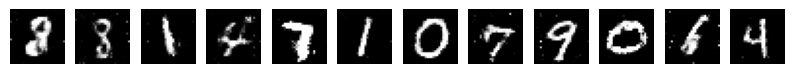

====> Epoch: 32 Generator loss: 0.0128 Discriminator loss: 0.0102


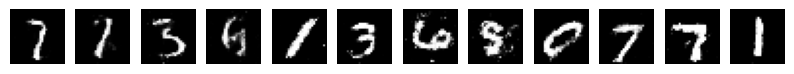

====> Epoch: 33 Generator loss: 0.0130 Discriminator loss: 0.0101


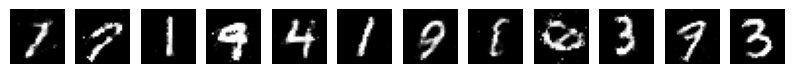

====> Epoch: 34 Generator loss: 0.0129 Discriminator loss: 0.0102


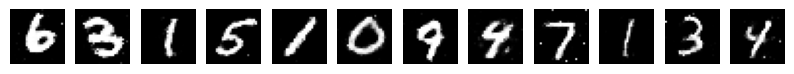

====> Epoch: 35 Generator loss: 0.0130 Discriminator loss: 0.0101


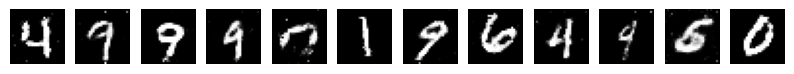

====> Epoch: 36 Generator loss: 0.0130 Discriminator loss: 0.0101


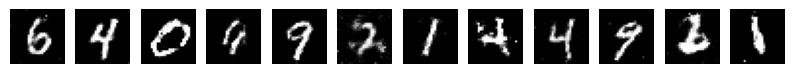

====> Epoch: 37 Generator loss: 0.0129 Discriminator loss: 0.0101


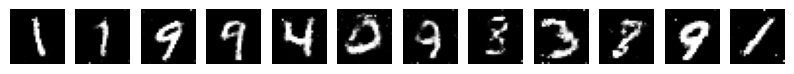

====> Epoch: 38 Generator loss: 0.0131 Discriminator loss: 0.0101


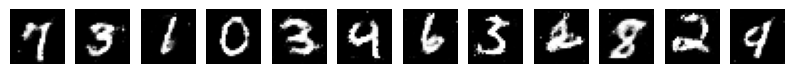

====> Epoch: 39 Generator loss: 0.0130 Discriminator loss: 0.0101


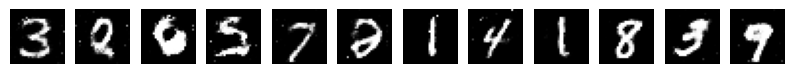

In [13]:
# 如果GPU可用，则使用cuda.FloatTensor，否则使用FloatTensor
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
# 定义训练轮数
n_epochs = 40

# 循环开始训练
for epoch in range(n_epochs):
    # 分别记录每轮生成器和判别器的loss
    generator_loss, discriminator_loss = 0, 0
    # 遍历训练数据集
    for batch_idx, (imgs, _) in enumerate(train_loader):

        # 定义真实标签的Tensor，数值全为1.0，不需要计算梯度
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        # 定义假标签的Tensor，数值全为0.0，不需要计算梯度
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # 将真实图片转化为Tensor
        real_imgs = Variable(imgs.type(Tensor))

        # 开始训练生成器
        optimizer_G.zero_grad()

        # 随机生成一个满足正态分布均值为0，方差为1的z
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], noise_dim))))

        # 通过生成器生成图片
        gen_imgs = generator(z)

        # 计算生成器的损失并记录
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        generator_loss += g_loss.item()

        # 反向传播并更新参数
        g_loss.backward()
        optimizer_G.step()

        # 开始训练判别器
        optimizer_D.zero_grad()

        # 计算判别器在真实图片上的损失
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        # 计算判别器在生成图片上的损失
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        
        # 计算判别器的总损失并记录
        d_loss = (real_loss + fake_loss) / 2
        discriminator_loss += d_loss.item()

        # 反向传播并更新参数
        d_loss.backward()
        optimizer_D.step()

    # 输出每一轮的生成器和判别器的平均损失
    print("====> Epoch: {} Generator loss: {:.4f} Discriminator loss: {:.4f}".format(
        epoch, generator_loss / len(train_loader.dataset), discriminator_loss / len(train_loader.dataset)))
    
    # 将最后生成的图片转换为numpy数组
    images = gen_imgs.view(-1, 28, 28).detach().cpu().numpy()
    # 可视化生成的样本
    fig, axs = plt.subplots(1, num_samples, figsize=(10,10))
    for i in range(num_samples):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].axis('off')
    plt.show()